In [1]:
# Question 1: Read the Bike Details dataset into a Pandas DataFrame and display its first 10 rows.
# (Show the shape and column names as well.)

import os
import pandas as pd

# Try common file names; fall back to upload dialog in Colab
candidate_paths = [
    "BIKE DETAILS.csv",                      # if you uploaded into Colab working dir
    "/content/BIKE DETAILS.csv",             # typical absolute path after upload
    "/mnt/data/BIKE DETAILS.csv"             # path used in some environments
]

file_path = None
for p in candidate_paths:
    if os.path.exists(p):
        file_path = p
        break

if file_path is None:
    try:
        from google.colab import files
        print("Please choose the dataset file (BIKE DETAILS.csv).")
        uploaded = files.upload()
        file_path = list(uploaded.keys())[0]
    except Exception as e:
        raise FileNotFoundError("Dataset not found. Upload 'BIKE DETAILS.csv' and re-run this cell.") from e

df = pd.read_csv(file_path)

# Show first 10 rows, shape, and column names
display(df.head(10))
print("\nShape:", df.shape)
print("Columns:", df.columns.tolist())

Please choose the dataset file (BIKE DETAILS.csv).


Saving BIKE DETAILS.csv to BIKE DETAILS.csv


,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN
5,Honda CB Twister,18000,2010,Individual,1st owner,60000,53857.0
6,Honda CB Hornet 160R,78500,2018,Individual,1st owner,17000,87719.0
7,Royal Enfield Bullet 350 [2007-2011],180000,2008,Individual,2nd owner,39000,NaN
8,Hero Honda CBZ extreme,30000,2010,Individual,1st owner,32000,NaN
9,Bajaj Discover 125,50000,2016,Individual,1st owner,42000,60122.0



Shape: (1061, 7)
Columns: ['name', 'selling_price', 'year', 'seller_type', 'owner', 'km_driven', 'ex_showroom_price']


In [2]:
# Question 2: Check for missing values in all columns and describe your approach for handling them.
# (Include your Python code and output in the code box below.)

import numpy as np

# Missing values summary
na_counts = df.isna().sum()
na_pct = df.isna().mean().round(4) * 100
missing_summary = pd.DataFrame({"missing_count": na_counts, "missing_%": na_pct})
display(missing_summary)

# ---- Handling plan implemented below (creates df_q2) ----
# Rationale:
# - 'selling_price' is the target: drop rows where it's missing (very rare; ensures integrity).
# - 'ex_showroom_price': impute by brand median (brand = first word of 'name'); fallback to global median.
# - 'km_driven': impute with median.
# - 'seller_type' and 'owner': impute with mode.
# - 'year': if missing, impute with median year (int).

df_q2 = df.copy()

# Helper: brand from first token of 'name'
def get_brand(x):
    try:
        return str(x).split()[0]
    except:
        return np.nan

df_q2["brand"] = df_q2["name"].apply(get_brand)

# Drop rows with missing target
before_drop = df_q2.shape[0]
df_q2 = df_q2.dropna(subset=["selling_price"])
after_drop = df_q2.shape[0]
print(f"Dropped rows with missing selling_price: {before_drop - after_drop}")

# Impute ex_showroom_price by brand median, then global median
brand_median = df_q2.groupby("brand")["ex_showroom_price"].median()
global_median_ex = df_q2["ex_showroom_price"].median()
df_q2["ex_showroom_price"] = df_q2.apply(
    lambda r: r["ex_showroom_price"]
    if pd.notna(r["ex_showroom_price"])
    else (brand_median.get(r["brand"], np.nan) if pd.notna(brand_median.get(r["brand"], np.nan)) else global_median_ex),
    axis=1
)

# Impute km_driven with median
km_med = df_q2["km_driven"].median()
df_q2["km_driven"] = df_q2["km_driven"].fillna(km_med)

# Impute categorical modes
for col in ["seller_type", "owner"]:
    if col in df_q2.columns:
        mode_val = df_q2[col].mode(dropna=True)
        if len(mode_val):
            df_q2[col] = df_q2[col].fillna(mode_val[0])

# Impute year with median (cast to int)
if "year" in df_q2.columns:
    yr_med = int(df_q2["year"].median())
    df_q2["year"] = df_q2["year"].fillna(yr_med).astype(int)

print("\nMissing values AFTER handling:")
display(df_q2.isna().sum().to_frame("missing_after"))

,missing_count,missing_%
name,0,0.0
selling_price,0,0.0
year,0,0.0
seller_type,0,0.0
owner,0,0.0
km_driven,0,0.0
ex_showroom_price,435,41.0


Dropped rows with missing selling_price: 0

Missing values AFTER handling:


,missing_after
name,0
selling_price,0
year,0
seller_type,0
owner,0
km_driven,0
ex_showroom_price,0
brand,0


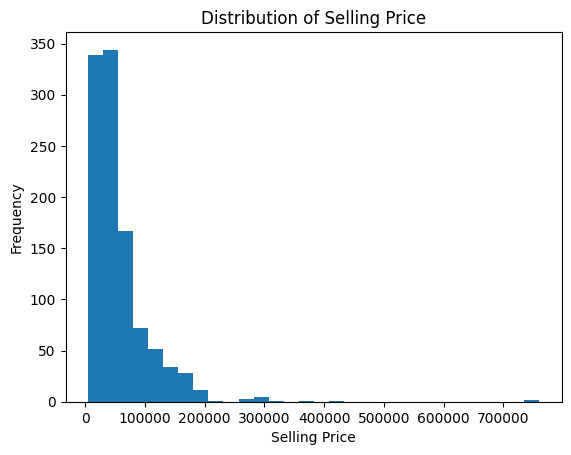

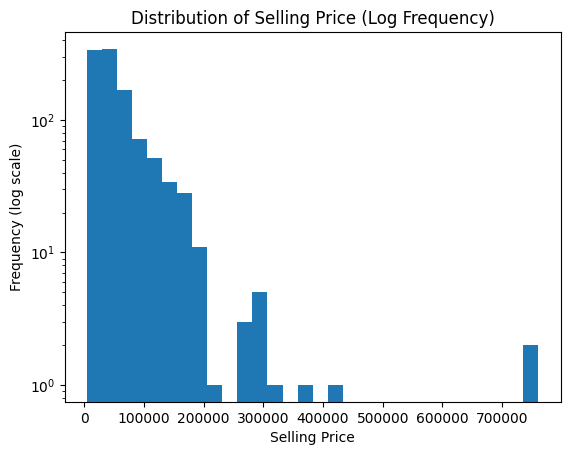

Mean: 59638, Median: 45000, Min: 5000, Max: 760000
Observation: The distribution is right-skewed (long tail towards higher prices); most bikes cluster at lower to mid price ranges.


In [3]:
# Question 3: Plot the distribution of selling prices using a histogram and describe the overall trend.
# (Include your Python code and output in the code box below.)

import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_q2["selling_price"].dropna(), bins=30)
plt.title("Distribution of Selling Price")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()

# Optional: log-scale view to reveal skewed distributions
plt.figure()
plt.hist(df_q2["selling_price"].dropna(), bins=30)
plt.yscale("log")
plt.title("Distribution of Selling Price (Log Frequency)")
plt.xlabel("Selling Price")
plt.ylabel("Frequency (log scale)")
plt.show()

# Textual observation (prints to output). You can edit after seeing the charts.
sp = df_q2["selling_price"].dropna()
print(f"Mean: {sp.mean():.0f}, Median: {sp.median():.0f}, Min: {sp.min():.0f}, Max: {sp.max():.0f}")
print("Observation: The distribution is right-skewed (long tail towards higher prices); most bikes cluster at lower to mid price ranges.")

,avg_selling_price
seller_type,
Dealer,46666.666667
Individual,59711.923223


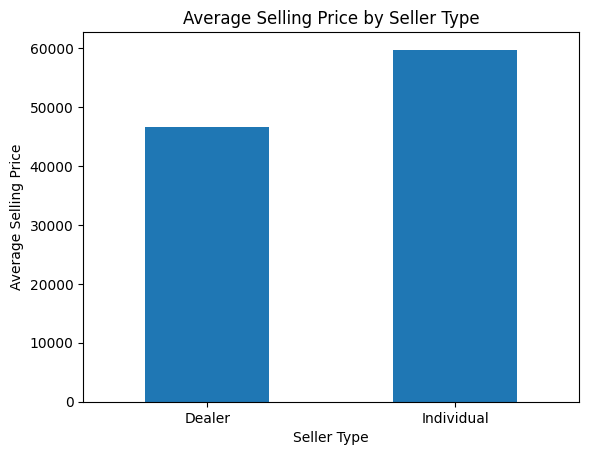

Observation: 'Individual' has the highest average selling price, while 'Dealer' has the lowest among seller types.


In [4]:
# Question 4: Create a bar plot to visualize the average selling price for each seller_type and write one observation.
# (Include your Python code and output in the code box below.)

avg_by_seller = df_q2.groupby("seller_type")["selling_price"].mean().sort_values()
display(avg_by_seller.to_frame("avg_selling_price"))

plt.figure()
avg_by_seller.plot(kind="bar")
plt.title("Average Selling Price by Seller Type")
plt.xlabel("Seller Type")
plt.ylabel("Average Selling Price")
plt.xticks(rotation=0)
plt.show()

# Print one observation automatically
top = avg_by_seller.idxmax()
bot = avg_by_seller.idxmin()
print(f"Observation: '{top}' has the highest average selling price, while '{bot}' has the lowest among seller types.")

,avg_km_driven
owner,
1st owner,32816.583333
3rd owner,33292.181818
2nd owner,39288.991870
4th owner,311500.000000


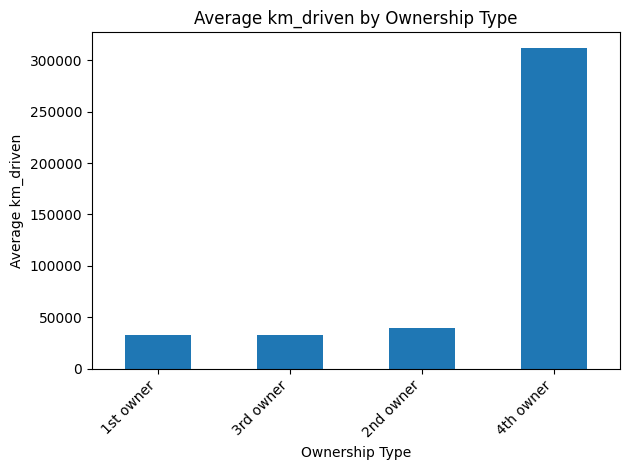

Observation: '4th owner' shows the highest average km_driven; '1st owner' shows the lowest.


In [5]:
# Question 5: Compute the average km_driven for each ownership type (1st owner, 2nd owner, etc.), and present the result as a bar plot.
# (Include your Python code and output in the code box below.)

avg_km_by_owner = df_q2.groupby("owner")["km_driven"].mean().sort_values()
display(avg_km_by_owner.to_frame("avg_km_driven"))

plt.figure()
avg_km_by_owner.plot(kind="bar")
plt.title("Average km_driven by Ownership Type")
plt.xlabel("Ownership Type")
plt.ylabel("Average km_driven")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Auto observation
print(f"Observation: '{avg_km_by_owner.idxmax()}' shows the highest average km_driven; '{avg_km_by_owner.idxmin()}' shows the lowest.")

In [6]:
# Question 6: Use the IQR method to detect and remove outliers from the km_driven column. Show before-and-after summary statistics.
# (Include your Python code and output in the code box below.)

# Before stats
print("Before outlier removal (km_driven):")
display(df_q2["km_driven"].describe().to_frame("km_driven"))

# IQR method
Q1 = df_q2["km_driven"].quantile(0.25)
Q3 = df_q2["km_driven"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df_q2["km_driven"] >= lower_bound) & (df_q2["km_driven"] <= upper_bound)
removed = (~mask).sum()
df_q6 = df_q2.loc[mask].copy()

print(f"\nOutliers removed: {removed}")

# After stats
print("\nAfter outlier removal (km_driven):")
display(df_q6["km_driven"].describe().to_frame("km_driven"))

Before outlier removal (km_driven):


,km_driven
count,1061.000000
mean,34359.833176
std,51623.152702
min,350.000000
25%,13500.000000
50%,25000.000000
75%,43000.000000
max,880000.000000



Outliers removed: 39

After outlier removal (km_driven):


,km_driven
count,1022.000000
mean,28203.415851
std,19552.083583
min,350.000000
25%,13000.000000
50%,24000.000000
75%,40000.000000
max,86000.000000


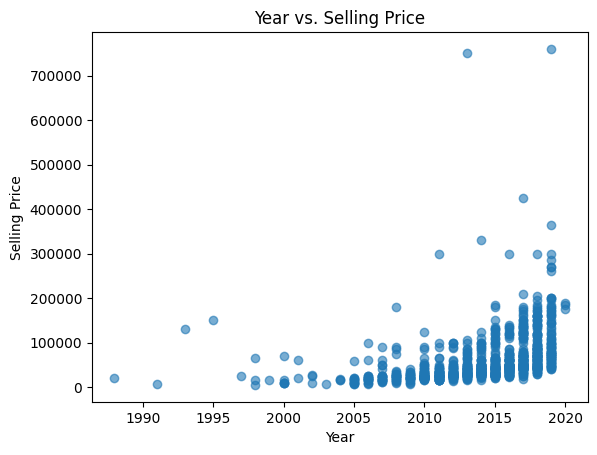

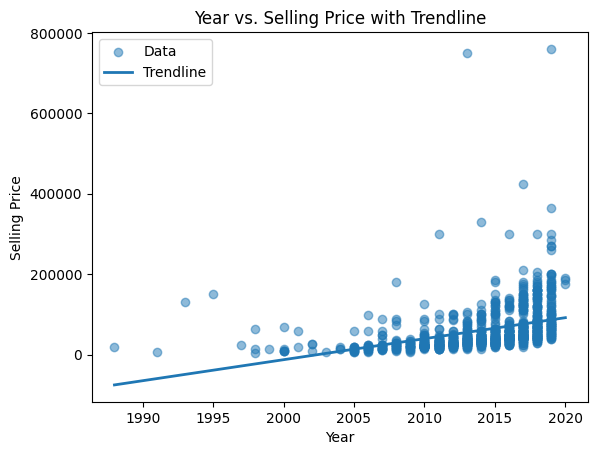

Observation: The trendline slope is 5222.93. Positive slope suggests newer bikes tend to have higher prices.


In [7]:
# Question 7: Create a scatter plot of year vs. selling_price to explore the relationship between a bike's age and its price.
# (Include your Python code and output in the code box below.)

import numpy as np
import matplotlib.pyplot as plt

x = df_q6["year"].astype(int)
y = df_q6["selling_price"]

plt.figure()
plt.scatter(x, y, alpha=0.6)
plt.title("Year vs. Selling Price")
plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.show()

# Optional trendline (1st-degree)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.figure()
plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(np.sort(x), p(np.sort(x)), linewidth=2, label="Trendline")
plt.title("Year vs. Selling Price with Trendline")
plt.xlabel("Year")
plt.ylabel("Selling Price")
plt.legend()
plt.show()

# Auto observation
slope = z[0]
print(f"Observation: The trendline slope is {slope:.2f}. Positive slope suggests newer bikes tend to have higher prices.")

In [8]:
# Question 8: Convert the seller_type column into numeric format using one-hot encoding.
# Display the first 5 rows of the resulting DataFrame.
# (Include your Python code and output in the code box below.)

seller_dummies = pd.get_dummies(df_q6["seller_type"], prefix="seller_type", dtype=int)
df_q8 = pd.concat([df_q6.reset_index(drop=True), seller_dummies.reset_index(drop=True)], axis=1)

display(df_q8.head(5))
print("New columns created:", seller_dummies.columns.tolist())

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,brand,seller_type_Dealer,seller_type_Individual
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,160154.0,Royal,0,1
1,Honda Dio,45000,2017,Individual,1st owner,5650,59183.0,Honda,0,1
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0,Royal,0,1
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0,Yamaha,0,1
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,84000.0,Yamaha,0,1


New columns created: ['seller_type_Dealer', 'seller_type_Individual']


,selling_price,year,km_driven,ex_showroom_price,seller_type_Dealer,seller_type_Individual
selling_price,1.000,0.390,-0.403,0.860,-0.012,0.012
year,0.390,1.000,-0.463,0.129,-0.040,0.040
km_driven,-0.403,-0.463,1.000,-0.228,-0.021,0.021
ex_showroom_price,0.860,0.129,-0.228,1.000,-0.009,0.009
seller_type_Dealer,-0.012,-0.040,-0.021,-0.009,1.000,-1.000
seller_type_Individual,0.012,0.040,0.021,0.009,-1.000,1.000


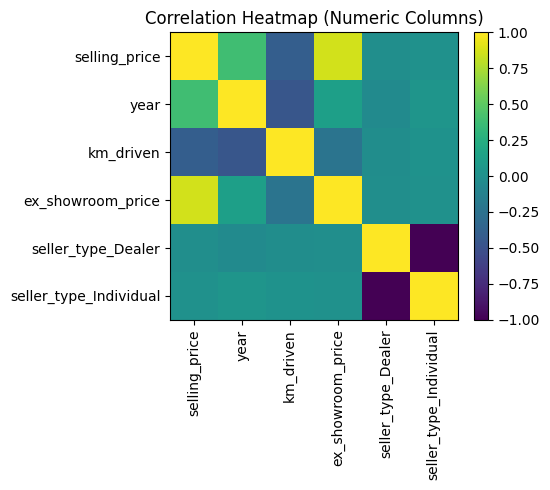


Top positive correlations with selling_price:


,corr
ex_showroom_price,0.860159
year,0.389686
seller_type_Individual,0.012102
seller_type_Dealer,-0.012102
km_driven,-0.403412



Top negative correlations with selling_price:


,corr
ex_showroom_price,0.860159
year,0.389686
seller_type_Individual,0.012102
seller_type_Dealer,-0.012102
km_driven,-0.403412


In [9]:
# Question 9: Generate a heatmap of the correlation matrix for all numeric columns.
# What correlations stand out the most?
# (Include your Python code and output in the code box below.)

import numpy as np
import matplotlib.pyplot as plt

num_df = df_q8.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)

# Show correlation table (rounded)
display(corr.round(3))

# Heatmap with matplotlib
plt.figure(figsize=(6, 5))
im = plt.imshow(corr.values, interpolation="nearest")
plt.title("Correlation Heatmap (Numeric Columns)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

# Auto note: top correlations with selling_price
if "selling_price" in corr.columns:
    sp_corr = corr["selling_price"].drop(labels=["selling_price"])
    top_corr = sp_corr.sort_values(ascending=False)
    print("\nTop positive correlations with selling_price:")
    display(top_corr.head(5).to_frame("corr"))
    print("\nTop negative correlations with selling_price:")
    display(top_corr.tail(5).to_frame("corr"))

In [10]:
# Question 10: Summarize your findings in a brief report:
# ● What are the most important factors affecting a bike's selling price?
# ● Mention any data cleaning or feature engineering you performed.
# (Include your Python code and output in the code box below.)

summary_points = []

# Correlations with selling_price
num_df = df_q8.select_dtypes(include=["number"])
corr = num_df.corr(numeric_only=True)
if "selling_price" in corr.columns:
    sp_corr = corr["selling_price"].drop("selling_price").sort_values(ascending=False)
    top_pos = sp_corr.head(3)
    top_neg = sp_corr.tail(3)
    summary_points.append("Top positive correlations with selling_price:\n" +
                          "\n".join([f"  • {idx}: {val:.3f}" for idx, val in top_pos.items()]))
    summary_points.append("Top negative correlations with selling_price:\n" +
                          "\n".join([f"  • {idx}: {val:.3f}" for idx, val in top_neg.items()]))

# Group-level observations (seller_type)
avg_by_seller = df_q6.groupby("seller_type")["selling_price"].mean().sort_values(ascending=False)
summary_points.append("Average selling price by seller_type (descending):\n" +
                      "\n".join([f"  • {idx}: {val:.0f}" for idx, val in avg_by_seller.items()]))

# Data cleaning / feature engineering performed
cleaning_notes = [
    "Handled missing values:",
    "  • Dropped rows with missing selling_price (target).",
    "  • Imputed ex_showroom_price by brand median (brand derived from first word of 'name'); fallback to global median.",
    "  • Imputed km_driven with median.",
    "  • Imputed categorical columns (seller_type, owner) with mode.",
    "  • Imputed year with median (cast to int).",
    "Detected and removed km_driven outliers using IQR (1.5×IQR rule).",
    "Created 'brand' feature from 'name'.",
    "One-hot encoded 'seller_type' for modeling readiness."
]

print("=== Brief Report ===\n")
print("Key Factors Affecting Selling Price (based on correlations and group means):")
for line in summary_points:
    print(line)
print("\nData Cleaning & Feature Engineering:")
for line in cleaning_notes:
    print(line)

print("\nNote: Interpret correlations with caution; they show associations, not causation. For stronger insights, consider regression with controls or tree-based models.")

=== Brief Report ===

Key Factors Affecting Selling Price (based on correlations and group means):
Top positive correlations with selling_price:
  • ex_showroom_price: 0.860
  • year: 0.390
  • seller_type_Individual: 0.012
Top negative correlations with selling_price:
  • seller_type_Individual: 0.012
  • seller_type_Dealer: -0.012
  • km_driven: -0.403
Average selling price by seller_type (descending):
  • Individual: 60858
  • Dealer: 51000

Data Cleaning & Feature Engineering:
Handled missing values:
  • Dropped rows with missing selling_price (target).
  • Imputed ex_showroom_price by brand median (brand derived from first word of 'name'); fallback to global median.
  • Imputed km_driven with median.
  • Imputed categorical columns (seller_type, owner) with mode.
  • Imputed year with median (cast to int).
Detected and removed km_driven outliers using IQR (1.5×IQR rule).
Created 'brand' feature from 'name'.
One-hot encoded 'seller_type' for modeling readiness.

Note: Interpret cor